In [1]:
!pip install pytorch_pretrained_bert pytorch-nlp

menpo 0.8.1 has requirement matplotlib<2.0,>=1.4, but you'll have matplotlib 3.0.2 which is incompatible.
menpo 0.8.1 has requirement pillow<5.0,>=3.0, but you'll have pillow 5.4.0 which is incompatible.
menpo 0.8.1 has requirement scipy<1.0,>=0.16, but you'll have scipy 1.2.0 which is incompatible.
You are using pip version 10.0.1, however version 19.2.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [1]:
import sys
import numpy as np
import random as rn
import torch
from pytorch_pretrained_bert import BertModel
from torch import nn
from torchnlp.datasets import imdb_dataset
from pytorch_pretrained_bert import BertTokenizer
from keras.preprocessing.sequence import pad_sequences
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.optim import Adam
from torch.nn.utils import clip_grad_norm_
from IPython.display import clear_output

/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
rn.seed(321)
np.random.seed(321)
torch.manual_seed(321)
torch.cuda.manual_seed(321)

## Prepare the Data

In [3]:
train_data, test_data = imdb_dataset(train=True, test=True)
rn.shuffle(train_data)
rn.shuffle(test_data)
train_data = train_data[:1000]
test_data = test_data[:100]

In [4]:
train_texts, train_labels = list(zip(*map(lambda d: (d['text'], d['sentiment']), train_data)))
test_texts, test_labels = list(zip(*map(lambda d: (d['text'], d['sentiment']), test_data)))

len(train_texts), len(train_labels), len(test_texts), len(test_labels)

(1000, 1000, 100, 100)

In [5]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [6]:
train_tokens = list(map(lambda t: ['[CLS]'] + tokenizer.tokenize(t)[:510] + ['[SEP]'], train_texts))
test_tokens = list(map(lambda t: ['[CLS]'] + tokenizer.tokenize(t)[:510] + ['[SEP]'], test_texts))

len(train_tokens), len(test_tokens)                   
                   

(1000, 100)

In [7]:
train_tokens_ids = pad_sequences(list(map(tokenizer.convert_tokens_to_ids, train_tokens)), maxlen=512, truncating="post", padding="post", dtype="int")
test_tokens_ids = pad_sequences(list(map(tokenizer.convert_tokens_to_ids, test_tokens)), maxlen=512, truncating="post", padding="post", dtype="int")

train_tokens_ids.shape, test_tokens_ids.shape

((1000, 512), (100, 512))

In [8]:
train_y = np.array(train_labels) == 'pos'
test_y = np.array(test_labels) == 'pos'
train_y.shape, test_y.shape, np.mean(train_y), np.mean(test_y)

((1000,), (100,), 0.489, 0.5)

In [9]:
train_masks = [[float(i > 0) for i in ii] for ii in train_tokens_ids]
test_masks = [[float(i > 0) for i in ii] for ii in test_tokens_ids]

# BERT outside the classifier

In [10]:
model = BertModel.from_pretrained('bert-base-uncased')

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device);

In [66]:
m = torch.tensor(train_masks[:1]).long().to(device)
x = torch.tensor(train_tokens_ids[:1]).long().to(device)

In [67]:
m.shape

torch.Size([1, 512])

In [68]:
x.shape

torch.Size([1, 512])

In [69]:
with torch.no_grad():
    y,pool = model(x,m)

In [70]:
pool.shape

torch.Size([1, 768])

In [71]:
for item in y:
    print (item.shape)

torch.Size([1, 512, 768])
torch.Size([1, 512, 768])
torch.Size([1, 512, 768])
torch.Size([1, 512, 768])
torch.Size([1, 512, 768])
torch.Size([1, 512, 768])
torch.Size([1, 512, 768])
torch.Size([1, 512, 768])
torch.Size([1, 512, 768])
torch.Size([1, 512, 768])
torch.Size([1, 512, 768])
torch.Size([1, 512, 768])


In [72]:
print ("Number of layers:", len(y))
layer_i = 0

print ("Number of batches:", len(y[layer_i]))
batch_i = 0

print ("Number of tokens:", len(y[layer_i][batch_i]))
token_i = 0

print ("Number of hidden units:", len(y[layer_i][batch_i][token_i]))

Number of layers: 12
Number of batches: 1
Number of tokens: 512
Number of hidden units: 768


In [73]:
import matplotlib.pyplot as plt
%matplotlib inline

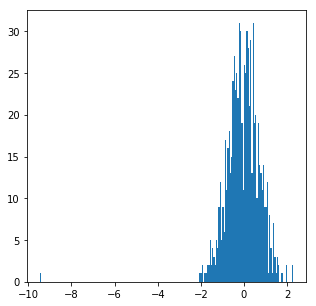

In [74]:
# For the 5th token in our sentence, select its feature values from layer 5.
token_i = 5
layer_i = 5
vec = y[layer_i][batch_i][token_i].cpu()

# Plot the values as a histogram to show their distribution.
plt.figure(figsize=(5,5))
plt.hist(vec, bins=200)
plt.show()

In [77]:
tokenized_text = train_tokens[0]
# Convert the hidden state embeddings into single token vectors

# Holds the list of 12 layer embeddings for each token
# Will have the shape: [# tokens, # layers, # features]
token_embeddings = [] 

# For each token in the sentence...
for token_i in range(len(tokenized_text)):
  
  # Holds 12 layers of hidden states for each token 
    hidden_layers = [] 
  
  # For each of the 12 layers...
    for layer_i in range(len(y)):
    
        # Lookup the vector for `token_i` in `layer_i`
        vec = y[layer_i][batch_i][token_i]
    
        hidden_layers.append(vec)
    
    token_embeddings.append(hidden_layers)

# Sanity check the dimensions:
print ("Number of tokens in sequence:", len(token_embeddings))
print ("Number of layers per token:", len(token_embeddings[0]))
print ("length of sentence:", len(tokenized_text))

Number of tokens in sequence: 328
Number of layers per token: 12
length of sentence: 328


In [91]:
len(token_embeddings[0][0]), token_embeddings[0][0].shape

(768, torch.Size([768]))

In [78]:
concatenated_last_4_layers = [torch.cat((layer[-1], layer[-2], layer[-3], layer[-4]), 0) for layer in token_embeddings] # [number_of_tokens, 3072]

summed_last_4_layers = [torch.sum(torch.stack(layer)[-4:], 0) for layer in token_embeddings] # [number_of_tokens, 768]

In [95]:
len(concatenated_last_4_layers), len(concatenated_last_4_layers[0])

(328, 3072)

In [96]:
768*4

3072

In [98]:
len(summed_last_4_layers), len(summed_last_4_layers[0])

(328, 768)

In [99]:
y[11].shape

torch.Size([1, 512, 768])

In [83]:
sentence_embedding = torch.mean(y[11], 1)

In [84]:
sentence_embedding.shape

torch.Size([1, 768])

In [85]:
print ("Our final sentence embedding vector of shape:"), sentence_embedding[0].shape[0]

Our final sentence embedding vector of shape:


(None, 768)

so basically, the entire sentence is embedded by taking the 11th layer of the output
and averaging the 768 long vector for each token into a single 768 element vector

In [100]:
for i,x in enumerate(tokenized_text):
    print (i,x)

0 [CLS]
1 i
2 loved
3 the
4 story
5 .
6 somewhere
7 ,
8 a
9 poster
10 said
11 there
12 are
13 no
14 families
15 like
16 the
17 one
18 portrayed
19 in
20 this
21 film
22 .
23 well
24 maybe
25 there
26 ought
27 to
28 be
29 .
30 i
31 thought
32 everybody
33 seemed
34 really
35 human
36 and
37 bel
38 ##ie
39 ##vable
40 .
41 what
42 a
43 top
44 notch
45 cast
46 .
47 what
48 great
49 music
50 on
51 the
52 soundtrack
53 .
54 what
55 a
56 nice
57 this
58 ,
59 and
60 what
61 a
62 nice
63 that
64 ,
65 but
66 most
67 of
68 all
69 ,
70 i
71 will
72 say
73 two
74 words
75 to
76 recommend
77 this
78 film
79 .
80 <
81 br
82 /
83 >
84 <
85 br
86 /
87 >
88 steve
89 care
90 ##ll
91 .
92 <
93 br
94 /
95 >
96 <
97 br
98 /
99 >
100 he
101 really
102 showed
103 a
104 nice
105 ,
106 subtle
107 depth
108 that
109 touched
110 me
111 .
112 he
113 was
114 truly
115 commanding
116 as
117 a
118 widow
119 ##er
120 who
121 had
122 dedicated
123 himself
124 maybe
125 a
126 little
127 too
128 much
129 to
130 being
131

In [101]:
print ("First fifteen values of 'truly':")
summed_last_4_layers[114][:15]

First fifteen values of 'truly':


tensor([ 1.2784, -1.1363,  7.1270, -0.7993,  2.7548,  1.6524,  4.2326, -1.4705,
         1.9733, -0.1732,  1.5759, -3.4783, -1.3119, -1.6201,  4.0390],
       device='cuda:0')

# Bert Model

In [55]:
class BertBinaryClassifier(nn.Module):
    def __init__(self, dropout=0.1):
        super(BertBinaryClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-uncased')

        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, tokens, masks=None):
        _, pooled_output = self.bert(tokens, attention_mask=masks, output_all_encoded_layers=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        proba = self.sigmoid(linear_output)
        return proba
        

In [56]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [57]:
str(torch.cuda.memory_allocated(device)/1000000 ) + 'M'

'438.881792M'

In [58]:
bert_clf = BertBinaryClassifier()
bert_clf = bert_clf.cuda()


In [59]:
str(torch.cuda.memory_allocated(device)/1000000 ) + 'M'

'438.881792M'

In [60]:
x = torch.tensor(train_tokens_ids[:3]).to(device)
y, pooled = bert_clf.bert(x, output_all_encoded_layers=False)
x.shape, y.shape, pooled.shape

(torch.Size([3, 512]), torch.Size([3, 512, 768]), torch.Size([3, 768]))

In [61]:
y = bert_clf(x)
y.cpu().detach().numpy()

array([[0.480183  ],
       [0.4748414 ],
       [0.40391952]], dtype=float32)

In [62]:
str(torch.cuda.memory_allocated(device)/1000000 ) + 'M'

'8010.245632M'

In [116]:
y, x, pooled = None, None, None
torch.cuda.empty_cache()
str(torch.cuda.memory_allocated(device)/1000000 ) + 'M'

'11563.497984M'

# Fine-tune BERT

In [64]:
BATCH_SIZE = 4
EPOCHS = 10

In [73]:
train_y = train_y.astype(float)
test_y = test_y.astype(float)

In [74]:
train_tokens_tensor = torch.tensor(train_tokens_ids)
train_y_tensor = torch.tensor(train_y.reshape(-1, 1)).float()

test_tokens_tensor = torch.tensor(test_tokens_ids)
test_y_tensor = torch.tensor(test_y.reshape(-1, 1)).float()

train_masks_tensor = torch.tensor(train_masks)
test_masks_tensor = torch.tensor(test_masks)

str(torch.cuda.memory_allocated(device)/1000000 ) + 'M'

'438.881792M'

In [75]:
train_dataset = TensorDataset(train_tokens_tensor, train_masks_tensor, train_y_tensor)
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=BATCH_SIZE)

test_dataset = TensorDataset(test_tokens_tensor, test_masks_tensor, test_y_tensor)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=BATCH_SIZE)


In [76]:
param_optimizer = list(bert_clf.sigmoid.named_parameters()) 
optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

In [79]:
optimizer = Adam(bert_clf.parameters(), lr=3e-6)

In [80]:
 torch.cuda.empty_cache()

In [81]:
for epoch_num in range(EPOCHS):
    bert_clf.train()
    train_loss = 0
    for step_num, batch_data in enumerate(train_dataloader):
        token_ids, masks, labels = tuple(t.to(device) for t in batch_data)
        print(str(torch.cuda.memory_allocated(device)/1000000 ) + 'M')
        logits = bert_clf(token_ids, masks)
        
        loss_func = nn.BCELoss()

        batch_loss = loss_func(logits, labels)
        train_loss += batch_loss.item()
        
        
        bert_clf.zero_grad()
        batch_loss.backward()
        

        clip_grad_norm_(parameters=bert_clf.parameters(), max_norm=1.0)
        optimizer.step()
        
        clear_output(wait=True)
        print('Epoch: ', epoch_num + 1)
        print("\r" + "{0}/{1} loss: {2} ".format(step_num, len(train_data) / BATCH_SIZE, train_loss / (step_num + 1)))
        

Epoch:  10
249/250.0 loss: 0.036980899441521616 


In [82]:
bert_clf.eval()
bert_predicted = []
all_logits = []
with torch.no_grad():
    for step_num, batch_data in enumerate(test_dataloader):

        token_ids, masks, labels = tuple(t.to(device) for t in batch_data)

        logits = bert_clf(token_ids, masks)
        loss_func = nn.BCELoss()
        loss = loss_func(logits, labels)
        numpy_logits = logits.cpu().detach().numpy()
        
        bert_predicted += list(numpy_logits[:, 0] > 0.5)
        all_logits += list(numpy_logits[:, 0])
    

In [83]:
np.mean(bert_predicted)

0.47

In [84]:
print(classification_report(test_y, bert_predicted))

              precision    recall  f1-score   support

         0.0       0.91      0.96      0.93        50
         1.0       0.96      0.90      0.93        50

   micro avg       0.93      0.93      0.93       100
   macro avg       0.93      0.93      0.93       100
weighted avg       0.93      0.93      0.93       100



In [85]:
len(bert_predicted)

100

In [86]:
bert_predicted[:10]

[True, False, False, True, False, True, True, True, True, False]

In [87]:
all_logits[:10]

[0.9994505,
 0.0006819216,
 0.00068550307,
 0.9993869,
 0.0007141872,
 0.9995022,
 0.9968591,
 0.9991862,
 0.52991986,
 0.0012265648]

In [100]:
batch_data = next(iter(test_dataloader))

In [102]:
len(batch_data)

3

In [103]:
x,y,z = tuple(t.to(device) for t in batch_data)

In [104]:
x.shape

torch.Size([4, 512])

In [105]:
y.shape

torch.Size([4, 512])

In [106]:
z.shape

torch.Size([4, 1])

In [107]:
x.cuda()
y.cuda()

tensor([[1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.]], device='cuda:0')

In [108]:
logits = bert_clf(x,y)

In [109]:
logits

tensor([[9.9945e-01],
        [6.8192e-04],
        [6.8550e-04],
        [9.9939e-01]], device='cuda:0', grad_fn=<SigmoidBackward>)

#### BERT without fine tuning

first we are going to embed each review with BERT

In [12]:
train_tensor_masks = torch.tensor(train_masks[:50]).long().to(device)
inputs = torch.tensor(train_tokens_ids[:50]).long().to(device)

In [13]:
masks.shape

torch.Size([100, 512])

In [14]:
inputs.shape

torch.Size([100, 512])

In [19]:
#making a dataloader outof the first 100 reviews
dataset = TensorDataset(inputs, masks)
sampler = RandomSampler(dataset)
dataloader = DataLoader(dataset, sampler=sampler, batch_size=4)

In [21]:
#this loop is just for embedding the input without training first.
# getting the whole 12 layer embedding + also the pooled output for each input
embedded_output = []
pooled_output = []
with torch.no_grad():
    for step_num, batch_data in enumerate(dataloader):
        print ('step:', step_num)
        token_ids, masks = tuple(t.to(device) for t in batch_data)
        #logits = bert_clf(token_ids, masks)
        embeds, pooled = model(token_ids, masks)
        embedded_output.append(embeds)
        pooled_output.append(pooled)
        

step: 0
step: 1
step: 2
step: 3
step: 4
step: 5
step: 6
step: 7
step: 8
step: 9
step: 10
step: 11


KeyboardInterrupt: 

stopped early because I got tired and impatient

In [22]:
#so we got 11 steps through, each of which is a batch of 4
len(embedded_output)

11

In [25]:
#the first batch
embedded_output[0]

[tensor([[[ 0.0195, -0.1025, -0.1798,  ...,  0.2839, -0.0542, -0.0541],
          [-0.6134,  0.0310, -0.0523,  ...,  0.2957,  0.2439,  0.2182],
          [-0.7719, -1.4415,  0.0866,  ...,  0.4891,  0.1766,  0.3654],
          ...,
          [ 0.9035, -0.0795, -0.5768,  ..., -0.0357,  0.5418, -0.5784],
          [ 0.9905, -0.2518, -0.0539,  ...,  0.0549,  0.0431, -0.2083],
          [ 0.3334, -0.7698, -0.3189,  ...,  0.0770,  0.6037, -1.2794]],
 
         [[ 0.0051, -0.1354, -0.1266,  ...,  0.0908,  0.1125,  0.0419],
          [-0.1086, -0.0718, -0.3147,  ...,  0.4675,  0.8267, -0.9194],
          [-0.7246,  0.2356, -0.2195,  ...,  0.3732,  0.4304, -0.0977],
          ...,
          [ 0.6090, -0.1513,  0.1237,  ..., -0.2063, -0.2100, -0.4494],
          [ 0.6491, -0.4255,  0.5876,  ...,  0.3462, -0.3546, -0.4542],
          [ 0.2439, -0.7559,  0.3585,  ...,  0.6854,  0.2912, -1.2619]],
 
         [[ 0.0432, -0.0272, -0.2169,  ...,  0.2831, -0.0093,  0.0498],
          [-0.5014, -0.3557,

In [40]:
#the first line in the output is is a list with 12 items
len(embedded_output[0])

12

In [43]:
for out in embedded_output[0]:
    print (out.shape)

torch.Size([4, 512, 768])
torch.Size([4, 512, 768])
torch.Size([4, 512, 768])
torch.Size([4, 512, 768])
torch.Size([4, 512, 768])
torch.Size([4, 512, 768])
torch.Size([4, 512, 768])
torch.Size([4, 512, 768])
torch.Size([4, 512, 768])
torch.Size([4, 512, 768])
torch.Size([4, 512, 768])
torch.Size([4, 512, 768])


so each item in the embedded output list, contains a list of 12 layers
within in item in this list is 4 examples from the batch
so the first item in each of these layers is from one input in the batch

In [44]:
#this will be the 11th layer for inputs 1 and 2 of this batch
embedded_output[0][11][0].shape, embedded_output[0][11][1].shape,

(torch.Size([512, 768]), torch.Size([512, 768]))

In [33]:
res=embedded_output[0][11][0].numpy()

In [35]:
res.shape, type(res)

((512, 768), numpy.ndarray)

In [36]:
len(pooled_output)

11

In [37]:
#each item in the pooled output is tensor, where each output corresponds in the pooled result of an input
pooled_output[0]

tensor([[ 0.7482,  0.3478,  0.8021,  ...,  0.4991,  0.4105, -0.5332],
        [ 0.3405, -0.3445, -0.8764,  ..., -0.6117, -0.4320,  0.1388],
        [ 0.8870,  0.6238,  0.9685,  ...,  0.8919,  0.7436, -0.6107],
        [ 0.8353,  0.4483,  0.8908,  ...,  0.7918,  0.6251, -0.7177]])

In [46]:
pooled_output[0].shape

torch.Size([4, 768])

In [39]:
pooled_output[0][0].shape

torch.Size([768])

In [47]:
#this is going to be an ugly way to turn my pooled layers back into a single input tensor
pooled_inputs = []
for item in pooled_output:
    for pool in item:
        pooled_inputs.append(pool)

In [52]:
#and same for the embeddings, as well
embedded_inputs = []
for item in embedded_output:
    for mat in item[11]:
        embedded_inputs.append(mat)

In [53]:
len(embedded_inputs)

44

In [55]:
embedded_inputs[0].shape

torch.Size([512, 768])

In [50]:
pooled_inputs[0].shape

torch.Size([768])

the problem with this is that I don't have labels to train with so I'm going to redo

In [65]:
train_tokens_tensor = torch.tensor(train_tokens_ids).long().to(device)
train_y_tensor = torch.tensor(train_y.reshape(-1, 1)).float()

test_tokens_tensor = torch.tensor(test_tokens_ids).long().to(device)
test_y_tensor = torch.tensor(test_y.reshape(-1, 1)).float()

train_masks_tensor = torch.tensor(train_masks).long().to(device)
test_masks_tensor = torch.tensor(test_masks)

In [66]:
train_dataset = TensorDataset(train_tokens_tensor[:50], train_masks_tensor[:50], train_y_tensor[:50])
#train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, batch_size=4)

test_dataset = TensorDataset(test_tokens_tensor[-10:], test_masks_tensor[-10:], test_y_tensor[:10])
#test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, batch_size=4)

In [67]:
#this loop is just for embedding the input without training first.
# getting the whole 12 layer embedding + also the pooled output for each input
embedded_output = []
pooled_output = []
with torch.no_grad():
    for step_num, batch_data in enumerate(train_dataloader):
        print ('step:', step_num)
        token_ids, masks, _ = tuple(t.to(device) for t in batch_data)
        #logits = bert_clf(token_ids, masks)
        embeds, pooled = model(token_ids, masks)
        embedded_output.append(embeds)
        pooled_output.append(pooled)
        

step: 0
step: 1
step: 2
step: 3
step: 4
step: 5
step: 6
step: 7
step: 8
step: 9
step: 10
step: 11
step: 12


In [68]:
#this is going to be an ugly way to turn my pooled layers back into a single input tensor
pooled_inputs = []
for item in pooled_output:
    for pool in item:
        pooled_inputs.append(pool)

In [69]:
#and same for the embeddings, as well
embedded_inputs = []
for item in embedded_output:
    for mat in item[11]:
        embedded_inputs.append(mat)

In [70]:
len(pooled_inputs), len(embedded_inputs)

(50, 50)

In [71]:
pooled_inputs[0].shape, embedded_inputs[0].shape

(torch.Size([768]), torch.Size([512, 768]))

In [60]:
class BertLinearClassifier(nn.Module):
    def __init__(self):
        self.linear = nn.Linear(768, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, inpute):
        linear_output = self.linear(inpute)
        proba = self.sigmoid(linear_output)
        return proba

In [ ]:
for epoch_num in range(EPOCHS):
    bert_clf.train()
    train_loss = 0
    for step_num, batch_data in enumerate(train_dataloader):
        token_ids, masks, labels = tuple(t.to(device) for t in batch_data)
        print(str(torch.cuda.memory_allocated(device)/1000000 ) + 'M')
        logits = bert_clf(token_ids, masks)
        
        loss_func = nn.BCELoss()

        batch_loss = loss_func(logits, labels)
        train_loss += batch_loss.item()
        
        
        bert_clf.zero_grad()
        batch_loss.backward()
        

        clip_grad_norm_(parameters=bert_clf.parameters(), max_norm=1.0)
        optimizer.step()
        
        clear_output(wait=True)
        print('Epoch: ', epoch_num + 1)
        print("\r" + "{0}/{1} loss: {2} ".format(step_num, len(train_data) / BATCH_SIZE, train_loss / (step_num + 1)))
        